In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import display
import heapq
import math
import skimage

In [7]:
image_array = np.genfromtxt('data.csv', delimiter=',',  dtype=int).astype(np.uint8)
star_pattern = np.array([
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 0]
])

erosion_array = skimage.morphology.erosion(image_array, footprint = star_pattern)

In [4]:
def astar(matrix, start, goal, pathConversionRate = 1):
    rows, cols = len(matrix), len(matrix[0])
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]

    # Define a helper function to check if a point is within the grid and is not an obstacle
    def is_valid(x, y):
        return 0 <= x < rows and 0 <= y < cols and matrix[x][y] != 0

    # Initialize data structures for the A* algorithm
    open_list = [(0, start)]
    came_from = {}
    g_score = {point: float('inf') for point in np.ndindex(matrix.shape)}
    g_score[start] = 0

    # Perform A* algorithm
    while open_list:
        _, current = heapq.heappop(open_list)

        if current == goal:
            break

        for dx, dy in directions:
            neighbor = (current[0] + dx, current[1] + dy)

            # Calculate the movement cost
            if dx != 0 and dy != 0:
                # Diagonal movement
                tentative_g_score = g_score[current] + math.sqrt(2)
            else:
                # Horizontal or vertical movement
                tentative_g_score = g_score[current] + 1

            if is_valid(*neighbor) and tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                heapq.heappush(open_list, (tentative_g_score + heuristic(neighbor, goal), neighbor))

    # Calculate length of the path
    path_length = g_score[goal] * pathConversionRate

    # Reconstruct the path
    path = []
    current = goal
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse()

    return path, path_length #return coordinates of path

# Heuristic function (Euclidean distance)
def heuristic(point, goal):
    return math.sqrt((point[0] - goal[0])**2 + (point[1] - goal[1])**2)

In [5]:
def shortestPath(matrix, start, goals, pathConversionRate = 1/15, addedStop = None):
  shortest_path = 0
  shortest_length = 10**20
  for starting in start:
    for target in goals:
      if addedStop == None :
        path,length = astar(matrix, starting, target, pathConversionRate)
        if (length < shortest_length):
          shortest_path = path
          shortest_length = length
      else :
        for coordinates in addedStop:
          path1, length1 = astar(matrix, starting , coordinates, pathConversionRate)
          path2, length2 = astar(matrix, coordinates, target, pathConversionRate)
          path = path1 + path2
          length = length1 + length2
          if (length < shortest_length):
            shortest_path = path
            shortest_length = length
  return shortest_path, shortest_length


def navigate(matrix, start, goal, addedStop = None):
  # if start building is not equal to goal building ---> navigate to building
  elevatorDist = 0
  bestPath = 0
  travelTime = 0       # travel time in s
  bestTime = 10**20
  walkingSpeed = 1.5   # m/s
  startingPoint = start

  if (start[1] != goal[1]):           # if you are not on the correct floor, navigate to an elevator or stair
    bestElevator = 0
    if start[2] == "North":
      elevatorDist = northDistance
    if start[2] == "West":
      elevatorDist = westDistance
    if start[2] == "South":
      elevatorDist = southDistance
    for i in range(len(elevatorDist)):
      path, pathLength = shortestPath(matrix, [elevator[i]], goal[3], addedStop = addedStop)
      currentLength = elevatorDist[i] + pathLength
      elevatorTime = 0
      travelTime = currentLength / walkingSpeed + elevatorTime
      if (travelTime < bestTime):
        bestTime = travelTime
        bestElevator = i
        bestPath = path

    if (bestElevator == 0):
      print("Go to floor",  goal[1], "using south elevator " )
    if (bestElevator == 1):
      print("Go to floor",  goal[1], "using the north elevator ")
    # navigate to elevator

    # add time for using elevator

    # add time for walking to goal
  else:
    bestPath, pathLength = shortestPath(matrix, start[3], goal[3], addedStop = addedStop)
    bestTime = pathLength/ walkingSpeed



  # if start position is not equal to goal position --> navigate to location
  #shortestPath(matrix, start, goal, addedStop = addedStop)
  return bestPath, travelTime

In [6]:
southDistance = (20, 100)
westDistance = (65, 55)
northDistance = (90 , 15)
entranceToElevator = [southDistance, westDistance, northDistance]   # entrance direction, distance to south elevator [m] and north elevator [m]
toilet_coor = [ (745,150) , (1860, 155) ]        # array with coordinates of toilets (I think)
elevator = [ (1875, 190) , (730,110)]            # south elevator, north elevator
randomRoom = [(1573, 70)]

Go to floor 8 using south elevator 
Path time is  77.87068461313878 seconds


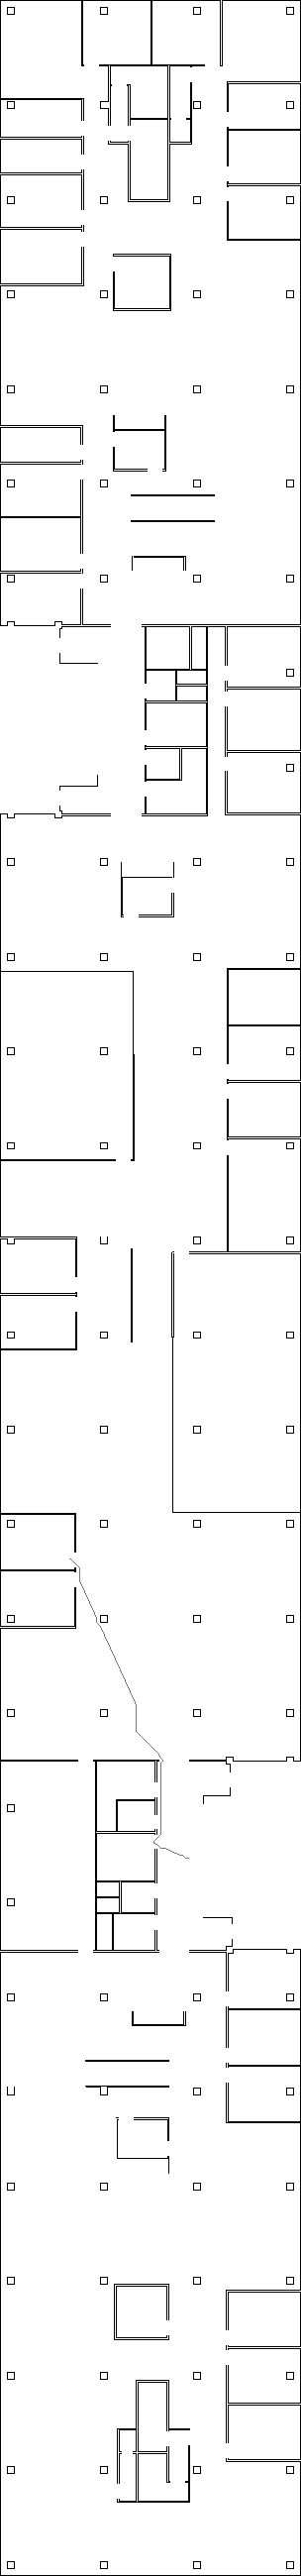

In [14]:
testStart = ["Atlas", 0 , "West", (0,0)]
testStart2 = ["Atlas", 8 , 294 , elevator ]
testGoal   = ["Atlas", 8 , 113 , randomRoom] #format : ["Building", floor, roomnumber, index]

path, time = navigate(erosion_array , testStart ,testGoal, addedStop= toilet_coor)
path_display = np.copy(image_array)
for coordinates in path:
  path_display[coordinates] = 120

path_image = Image.fromarray(path_display, mode='L')
#path_image = path_image.resize((int(fig_width*0.02),int(fig_height*0.02)))
print("Path time is ", time ,"seconds")
display(path_image)

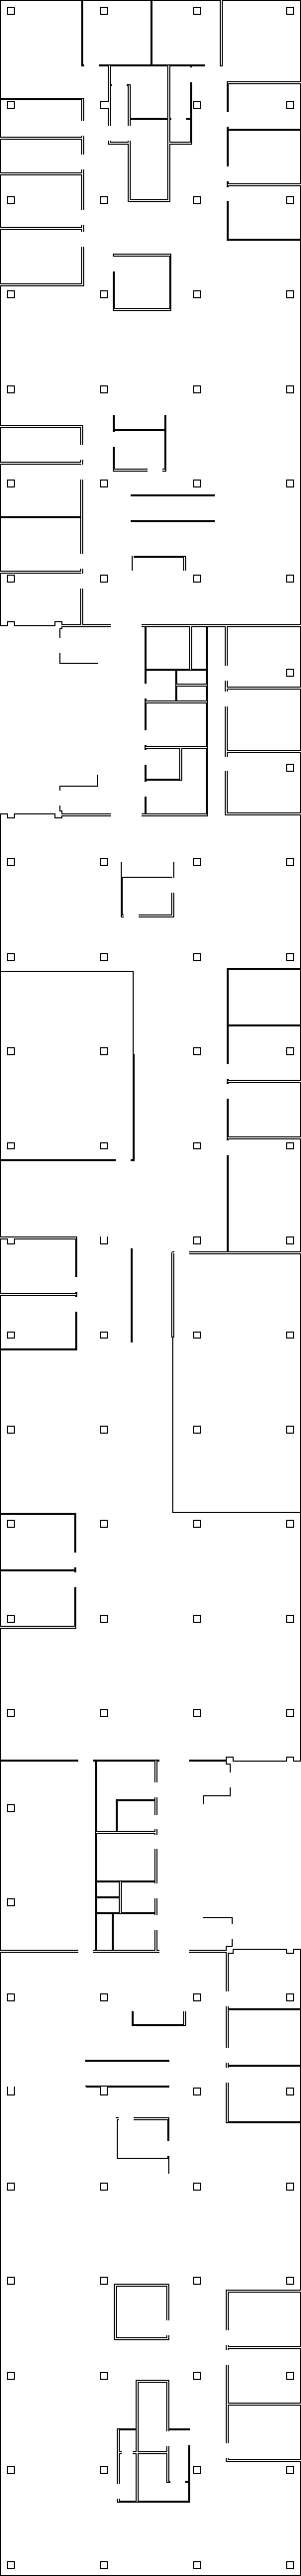

In [12]:
image = Image.fromarray(image_array, mode='L')
display(image)